In [71]:
from gensim.models import Doc2Vec
import smart_open
from gensim.models.doc2vec import TaggedDocument

import multiprocessing
from tqdm import tqdm
cores = multiprocessing.cpu_count()

import numpy as np

import pandas as pd
df=pd.read_json("un_speeches_2019_labels.json",orient='records',compression='infer')

In [72]:
df[df['ISO Code']=="IND"]

,doc,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Language,Notes,sent_split,word_split,count_speech_words,count_speech_sent,word_split_withoutgpe,labels
78,It is a great honour for me to address the Gen...,2019,74,IND,Republic of India,Mr. Narendra Modi,Prime Minister,Hindi,English interpretation provided by the delegation,[It is a great honour for me to address the Ge...,"[It, is, a, great, honour, for, me, to, addres...",1353,52,"[It, is, a, great, honour, for, me, to, addres...",CLUSTER 7


In [73]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(42)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Prakhar
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

In [75]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country',
       'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split',
       'word_split', 'count_speech_words', 'count_speech_sent',
       'word_split_withoutgpe', 'labels'],
      dtype='object')

In [76]:
stoppers=set(gensim.parsing.preprocessing.STOPWORDS)
problem_specific=set(["want",'help','seek','home','please','hear','congratulations','reiterate','form','want','wish','happen','president','open','talk',
                      'trust','general','assembly','let','convey','congratulate','thank','thanks','allow','Let','begin',' pleased','secretary-general'])
stoppers=stoppers.union(problem_specific)

In [77]:
def preprocess(text):
    result = []
    for token in text:
        if token.lower() not in stoppers and len(token) > 3:
            result.append(lemmatize(token))
    return result

In [78]:
df['clean_text']=df['word_split_withoutgpe'].apply(preprocess)

In [79]:
df['clean_text']

0      [honour, stand, prestigious, rostrum, today, r...
1      [like, salute, present, important, rostrum, ho...
2      [seven, decades, rostrum, raise, bear, weight,...
3      [like, address, seventy-fourth, session, congr...
4      [outset, like, seventy-fourth, session, Maria,...
                             ...                        
190    [Today, adopt, Political, Declaration, High-le...
191    [behalf, people, Republic, sincerely, Tijjani,...
192    [stand, deeply, move, coincidence, speak, foll...
193    [join, previous, speakers, congratulate, Excel...
194    [Tijjani, Muhammad-Bande, election, seventy-fo...
Name: clean_text, Length: 195, dtype: object

In [80]:
s=df['labels'].unique()

In [81]:
import multiprocessing

cores=multiprocessing.cpu_count()

In [82]:
s[0:2]
from gensim.models import CoherenceModel
cluster_models={}

In [83]:
log = open("LDA_results_2019.txt","w")
file = log
for i in s:
    print("____________________________________________________________________________________",file = log)
    print(i,file = log)
    cluster_models[i]={}
    print("____________________________________________________________________________________",file = log)
    df1=df[df['labels']==i]
    print("--------Countries-----",file = log)
    for ccc in df1['Country'].unique():
        print(ccc,end="\t",file = log)
    print(file = log)
    cluster_models[i]['Country']=[i for i in df1['Country'].unique()]
    cluster_models[i]['ISO Code']=[i for i in df1['ISO Code'].unique()]
    print("-----------------------",file = log)
    processed_docs=df1['clean_text']
#     print(processed_docs)
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#     print(bow_corpus)
    
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=4, workers=cores,random_state=1)
    cluster_models[i]['model']=lda_model
    for idx, topic in lda_model.print_topics(-1):
        topi=str(topic)
        cluster_models[i]['Topic: {}'.format(idx)]=topic
        print('Topic: {}'.format(idx),file = log)
        tt=topi.split("+")
        for n in tt:
            n1=n.split("*")
            print(n1[0],n1[1],file = log)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda,file = log)
    cluster_models[i]['Coherence Score']=coherence_lda
    perplexity = lda_model.log_perplexity(bow_corpus)
    print('\nPerplexity Score: ', perplexity,file = log)
    cluster_models[i]['Perplexity Score']=perplexity
log.close()

In [84]:
output=pd.DataFrame(cluster_models).transpose().reset_index()

In [85]:
output=output.explode('ISO Code')

In [86]:
output.columns

Index(['index', 'Country', 'ISO Code', 'model', 'Topic: 0', 'Topic: 1',
       'Topic: 2', 'Coherence Score', 'Perplexity Score'],
      dtype='object')

In [87]:
output.dtypes

index               object
Country             object
ISO Code            object
model               object
Topic: 0            object
Topic: 1            object
Topic: 2            object
Coherence Score     object
Perplexity Score    object
dtype: object

In [88]:
import plotly.express as px



In [89]:
def cleaner(x):
    f=[]
    y=x.split("+")
    for i in y:
        ff=i.split("*")
        f.append(ff[1].replace('"',''))
    f=f[0:2]    
    return f    

In [90]:
def cleaner2(x):
    f=[]
    y=x.split("+")
    for i in y:
        ff=i.split("*")
        f.append(ff[1].replace('"',''))  
    f=f[0:6]
    return ','.join(f)

In [91]:
output["Discussion1"]=output['Topic: 0'].apply(cleaner)
output["Discussion2"]=output['Topic: 1'].apply(cleaner)
output["Discussion3"]=output['Topic: 2'].apply(cleaner)
output["Major Topics 1"]=output['Topic: 0'].apply(cleaner2)
output["Major Topics 2"]=output['Topic: 1'].apply(cleaner2)
output["Major Topics 3"]=output['Topic: 2'].apply(cleaner2)

In [92]:
output["Discussion1"]

0     [Afghan , SIDS ]
0     [Afghan , SIDS ]
0     [Afghan , SIDS ]
0     [Afghan , SIDS ]
0     [Afghan , SIDS ]
            ...       
13    [course , life ]
13    [course , life ]
13    [course , life ]
13    [course , life ]
13    [course , life ]
Name: Discussion1, Length: 195, dtype: object

In [93]:
output["Discussion Topics"]=output["Discussion1"]+output["Discussion2"]+output["Discussion3"]

In [94]:
output["Discussion Topics"]=output["Discussion Topics"].apply(set)
# output["Discussion Topics"]=output["Discussion Topics"].apply(str)

In [95]:
output["Discussion Topics"]=[','.join(map(str, l)) for l in output['Discussion Topics']]

In [108]:
output["Discussion Topics"].unique()

array(['Solomon ,Vanuatu ,SIDS ,Afghan ,Islands ',
       'Nagorno ,health ,South ,school ,2020 ,region ',
       'Cabo ,Mauritius ,Caribbean ,choose ,Tobago ',
       'Marino ,technological ,Paraguay ,Democratic ,Africa ,participation ',
       'brother ,crisis ,Africa ,Sahel ,Sudanese ,revolution ',
       'Lanka ,protection ,like ,small ,transition ,European ',
       'justice ,young ,democracy ,multilateralism ,listen ,military ',
       'terrorism ,South ,fight ,Sahel ,rule ,nations ',
       'Iranian ,Turkish ,militias ,regime ,Cyprus ,Israeli ',
       'North ,Dushanbe ,neutrality ,drug ,European ,Kyrgyz ',
       'Muslims ,Kashmir ,measure ,indigenous ,entire ,Republic ',
       'know ,talk ,fight ,develop ,sustainability ,Africa ',
       'Gabon ,Summit ,greater ,create ,threats ',
       'course ,courage ,life ,nations ,care ,agenda '], dtype=object)

In [97]:
output["Perplexity Score"]=output["Perplexity Score"].astype(float)
output["Coherence Score"]=output["Coherence Score"].astype(float)

In [98]:
color_seq = ['#AA0DFE',

 '#565656',
 '#1C8356',
 '#16FF32',
 '#F7E1A0',
 '#1CBE4F',
 '#C4451C',
 '#DEA0FD',
 '#FE00FA',
 '#325A9B',
 '#FEAF16',
 '#F8A19F',
 '#90AD1C',
 '#F6222E',
 '#1CFFCE',
 '#2ED9FF',
 '#B10DA1',
 '#C075A6',
 '#FC1CBF',
 '#B00068',
 '#FBE426',
 '#FA0087']


In [99]:
fig = px.choropleth(output, locations="ISO Code",
                    color="Discussion Topics", # lifeExp is a column of gapminder
                    hover_data=["Perplexity Score",'index','Coherence Score',"Major Topics 1","Major Topics 2","Major Topics 3"] # column to add to hover information
,width=1300,height=700,color_discrete_sequence=color_seq,title="Major Topics in 2019 UNGA Speeches")
fig.show()

In [100]:
fig.write_html("speechs_2019_worldmap with topics.html")

In [101]:
output['year']=2019

In [102]:
output.to_json("cluster_2019.json",orient='records',compression='infer')

In [103]:
output
measures=output[['index','Coherence Score','Perplexity Score']].groupby('index').mean()

In [104]:
measures=measures.reset_index()

In [105]:
from matplotlib import pyplot as plt

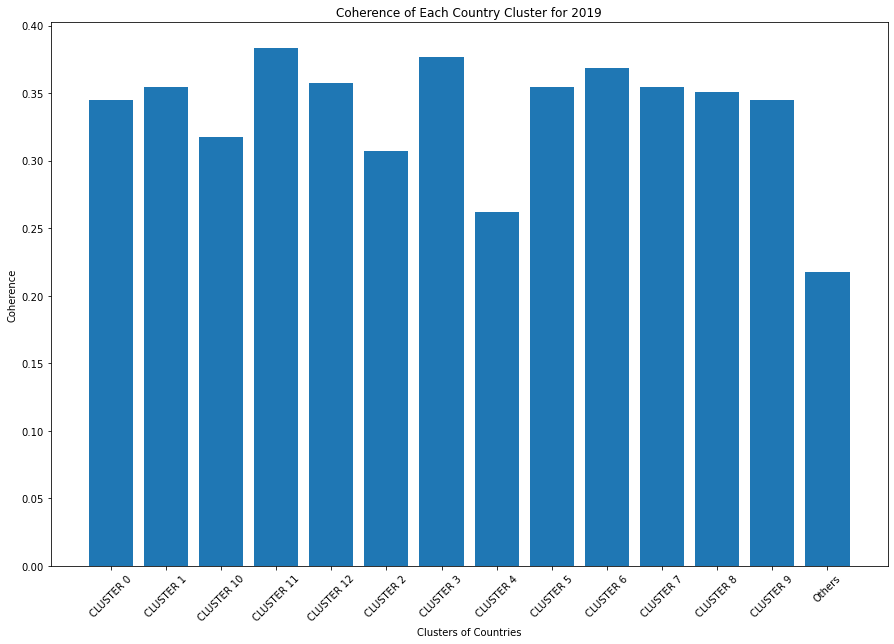

In [106]:
plt.figure(figsize=(15,10))
plt.bar(measures['index'], measures['Coherence Score'])
plt.xticks(rotation = 45)
# Show Plot
plt.xlabel("Clusters of Countries")
plt.ylabel("Coherence")
plt.title("Coherence of Each Country Cluster for 2019")
plt.show()


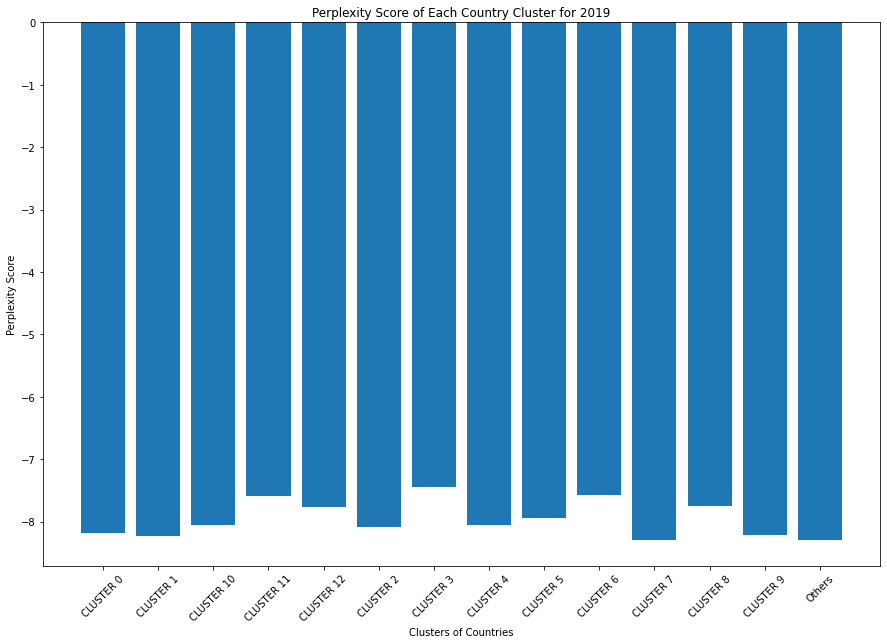

In [107]:
plt.figure(figsize=(15,10))
plt.bar(measures['index'], measures['Perplexity Score'])
plt.xticks(rotation = 45)
# Show Plot
plt.xlabel("Clusters of Countries")
plt.ylabel("Perplexity Score")
plt.title("Perplexity Score of Each Country Cluster for 2019")
plt.show()
